In [14]:
import os
os.environ["SAFETENSORS_FAST_SAVE"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

import random
import shutil
from pathlib import Path

import json

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import segmentation_models_pytorch as smp           

import albumentations as A

In [15]:
project_root = Path.cwd() / "DATASET"

In [16]:
def split_data(root_dir: str, split_ratio=0.8):
    root = Path(root_dir)
    seg_dir = root / "Segmentation"

    pairs = []
    for tumor_type in seg_dir.iterdir():
        for mask_path in tumor_type.glob("*_mask.png"):
            base_stem = mask_path.stem[:-5]
            img_path = tumor_type / f"{base_stem}.png"
            pairs.append((img_path, mask_path))

    print(f"Found {len(pairs)} image–mask pairs.")

    random.shuffle(pairs)
    split_idx = int(len(pairs) * split_ratio)
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]

    for split in ["train", "val"]:
        (root / split / "images").mkdir(parents=True, exist_ok=True)
        (root / split / "masks").mkdir(parents=True, exist_ok=True)

    def copy_pairs(pairs, split_name):
        for img_path, mask_path in pairs:
            shutil.copy(img_path, root / split_name / "images" / img_path.name)
            shutil.copy(mask_path, root / split_name / "masks" / mask_path.name)

    copy_pairs(train_pairs, "train")
    copy_pairs(val_pairs, "val")

    print(f"Split {len(train_pairs)} train and {len(val_pairs)} val samples.")
    print(f" Training data:  → {root/'train'}")
    print(f" Validation data:  → {root/'val'}")

if not ((project_root / "train").exists() and (project_root / "val").exists()):
    split_data(project_root)

Found 2192 image–mask pairs.
Split 1753 train and 439 val samples.
 Training data:  → /Users/adam/deep-machine-learning/Project/DATASET/train
 Validation data:  → /Users/adam/deep-machine-learning/Project/DATASET/val


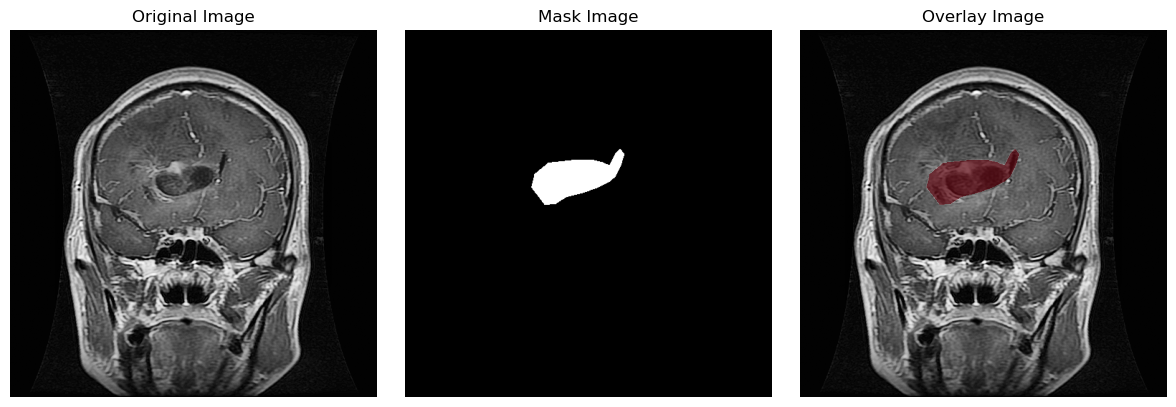

In [ ]:
def plot_image_and_mask(index: int, split: str = "train"):
    images_dir = project_root / split / "images"
    masks_dir  = project_root / split / "masks"

    img_path  = sorted(images_dir.glob("*.png"))[index]
    mask_path = masks_dir / f"{img_path.stem}_mask.png"

    img  = np.array(Image.open(img_path))
    mask = (np.array(Image.open(mask_path)) > 127).astype(float)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap="gray")
    plt.imshow(mask, cmap="Reds", alpha=0.6 * mask)
    plt.title("Overlay Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_image_and_mask(754, split="train")



In [6]:
IMG_SIZE   = (512, 512)
BATCH_SIZE = 16
EPOCHS     = 100
BASE_CH    = 32
LR         = 0.001
PROJECT_ROOT = project_root

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: mps


In [7]:
class DSConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, 3, 1, 1, groups=in_ch, bias=False),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, 1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.seq(x)

class Encoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DSConvBlock(in_ch, out_ch)
        self.pool = nn.MaxPool2d(2)
    def forward(self, x):
        s = self.conv(x)
        return self.pool(s), s

class Decoder(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.conv = DSConvBlock(out_ch * 2, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class BrainTumorSegmentationModel(nn.Module):

    def __init__(self, in_ch=1, out_ch=1, base=BASE_CH):
        super().__init__()
        self.d1 = Encoder(in_ch,         base)
        self.d2 = Encoder(base,          base * 2)
        self.d3 = Encoder(base * 2,      base * 4)
        self.d4 = Encoder(base * 4,      base * 8)

        self.bottleneck = DSConvBlock(base * 8, base * 16)

        self.u4 = Decoder(base * 16,     base * 8)
        self.u3 = Decoder(base * 8,      base * 4)
        self.u2 = Decoder(base * 4,      base * 2)
        self.u1 = Decoder(base * 2,      base)

        self.head = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        x, s1 = self.d1(x)
        x, s2 = self.d2(x)
        x, s3 = self.d3(x)
        x, s4 = self.d4(x)
        x = self.bottleneck(x)
        x = self.u4(x, s4)
        x = self.u3(x, s3)
        x = self.u2(x, s2)
        x = self.u1(x, s1)
        return self.head(x)

In [8]:
def _simulate_mri_contrast(img: np.ndarray, **kwargs) -> np.ndarray:

    g = img.astype(np.float32) / 255.0

    mode = np.random.choice(["T1", "T2", "FLAIR"])
    gamma_lo = {"T1": 0.8, "T2": 0.9, "FLAIR": 1.0}[mode]
    gamma_hi = {"T1": 1.2, "T2": 1.3, "FLAIR": 1.4}[mode]
    gamma = np.random.uniform(gamma_lo, gamma_hi)

    if mode == "FLAIR":
        g = g / (1.0 + np.exp(8.0 * (g - 0.85))) 

    if mode != "T1":
        g = 1.0 - g  

    g = np.power(np.clip(g, 0.0, 1.0), gamma)

    g8 = np.uint8(np.clip(g * 255.0, 0, 255))
    g8 = cv2.createCLAHE(
        clipLimit=np.random.uniform(1.5, 3.0),
        tileGridSize=(8, 8)
    ).apply(g8)

    return g8  


def get_transforms(train=True):
    if train:
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.Lambda(image=_simulate_mri_contrast, p=0.7),
        ])
    else:
        return A.Compose([])


class SegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, resize=None, preload=True, transform=None, name=""):
        self.imgs = sorted(Path(img_dir).glob("*.png"))
        self.mask_dir = Path(mask_dir)
        self.resize = resize
        self.transform = transform
        self.name = name

        self.data = [self._read(p) for p in tqdm(self.imgs, desc=f"Preload {self.name}", leave=False)]

    def _read(self, p):
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.resize, interpolation=cv2.INTER_LINEAR)

        mpath = self.mask_dir / f"{p.stem}_mask.png"
        m = Image.open(mpath).convert("L")
        m = m.resize(self.resize, resample=Image.NEAREST)
        mask = (np.array(m) > 127).astype(np.uint8)

        return img, mask

    def __getitem__(self, i):
        img, mask = self.data[i]
        if self.transform:
            out = self.transform(image=img, mask=mask)
            img, mask = out["image"], out["mask"]

        img_t = torch.from_numpy(img).unsqueeze(0).float() / 255.0  
        mask_t = torch.from_numpy(mask).unsqueeze(0).float()
        return img_t, mask_t, self.imgs[i].name

    def __len__(self):
        return len(self.imgs)




In [9]:
dice_loss_fn = smp.losses.DiceLoss(mode="binary", from_logits=True)
bce_loss_fn  = smp.losses.SoftBCEWithLogitsLoss()

@torch.no_grad()
def dice_metric(preds, targets, threshold=0.5, eps=1e-6):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum()
    return (2 * intersection + eps) / (union + eps)


def build_loaders(root=PROJECT_ROOT, batch=BATCH_SIZE):
    tr = SegmentationDataset(f"{root}/train/images", f"{root}/train/masks",
                             resize=IMG_SIZE, preload=True, transform=get_transforms(True),  name="train")
    va = SegmentationDataset(f"{root}/val/images",   f"{root}/val/masks",
                             resize=IMG_SIZE, preload=True, transform=get_transforms(False), name="val")
    trL = DataLoader(tr, batch_size=batch, shuffle=True)
    vaL = DataLoader(va, batch_size=batch, shuffle=False)
    return trL, vaL

def make_transfer_unet(encoder="resnet34", in_ch=1, out_ch=1, weights="imagenet"):
    return smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,   
        in_channels=in_ch,
        classes=out_ch,
        activation=None
    )

def freeze_encoder(model, freeze=True):
    if hasattr(model, "encoder"):
        for p in model.encoder.parameters():
            p.requires_grad = not freeze


def make_discriminative_opt(model, lr_body, lr_head, weight_decay=1e-4):
    enc = list(model.encoder.parameters())
    dec = [p for n, p in model.named_parameters() if not n.startswith("encoder.")]
    return torch.optim.AdamW(
        [{"params": enc, "lr": lr_body},
         {"params": dec, "lr": lr_head}],
        weight_decay=weight_decay
    )




In [10]:
def run_epoch(model, loader, opt=None, phase_name="Train"):
    train = opt is not None
    model.train(train)

    total_loss, total_dice = 0.0, 0.0
    device_type = device.type
    use_amp = device_type == "cuda"   # AMP only on CUDA (not on MPS/CPU)

    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    for imgs, masks, _ in tqdm(
        loader,
        leave=False,
        dynamic_ncols=False,
        disable=False,
        desc=phase_name
    ):
        imgs, masks = imgs.to(device), masks.to(device)

        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(imgs)
            loss = 0.3 * dice_loss_fn(out, masks) + 0.7 * bce_loss_fn(out, masks)

        if train:
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()

        total_loss += loss.item()
        total_dice += dice_metric(out, masks).item()

    avg_loss = total_loss / len(loader)
    avg_dice = total_dice / len(loader)

    return avg_loss, avg_dice


def train_eval(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, tag="model",
               epoch_freeze=0, use_discriminative_lr=False, root=PROJECT_ROOT):
    model = model.to(device)

    if use_discriminative_lr:
        opt = make_discriminative_opt(model, lr_body=lr * 0.1, lr_head=lr)
    else:
        opt = torch.optim.AdamW(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=3)

    model.history = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

    best_val = float("inf")
    best_path = f"{root}/{tag}.pt"
    hist_path = f"{root}/{tag}.json"

    freeze_encoder(model, True)

    print(f"{'='*80}")
    print(f"{tag}")
    print(f"{'='*80}\n")

    for e in range(1, epochs + 1):
        if epoch_freeze and e == epoch_freeze + 1:
            freeze_encoder(model, False)

        tr_loss, tr_dice = run_epoch(model, train_loader, opt,  phase_name=f"{tag} Train {e:02d}")
        va_loss, va_dice = run_epoch(model, val_loader,   None, phase_name=f"{tag} Val   {e:02d}")

        model.history["train_loss"].append(float(tr_loss))
        model.history["train_dice"].append(float(tr_dice))
        model.history["val_loss"].append(float(va_loss))
        model.history["val_dice"].append(float(va_dice))

        print(f"[Epoch {e:02d}] training_loss={tr_loss:.4f} val_loss={va_loss:.4f} | training_dice={tr_dice:.4f} val_dice={va_dice:.4f}")

        if va_loss < best_val:
            best_val = va_loss
            torch.save(model.state_dict(), best_path)

        scheduler.step(va_loss)

        with open(hist_path, "w") as f:
            json.dump(model.history, f, indent=2)

    return model, best_path

/home/adam25franzen/conda/envs/dml/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_9246/704220600.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


U-net architecture



U-net architecture Train 01:   0%|          | 0/110 [00:00<?, ?it/s]/tmp/ipykernel_9246/704220600.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[Epoch 01] training_loss=0.5098 val_loss=0.3772 | training_dice=0.0083 val_dice=0.0000


[Epoch 02] training_loss=0.3507 val_loss=0.3768 | training_dice=0.0210 val_dice=0.1764


[Epoch 03] training_loss=0.3019 val_loss=0.2664 | training_dice=0.2390 val_dice=0.3499


[Epoch 04] training_loss=0.2755 val_loss=0.2408 | training_dice=0.3117 val_dice=0.4152


[Epoch 05] training_loss=0.2634 val_loss=0.2537 | training_dice=0.3370 val_dice=0.3811


[Epoch 06] training_loss=0.2541 val_loss=0.2654 | training_dice=0.3590 val_dice=0.3601


[Epoch 07] training_loss=0.2437 val_loss=0.2130 | training_dice=0.3862 val_dice=0.4783


[Epoch 08] training_loss=0.2387 val_loss=0.2091 | training_dice=0.3977 val_dice=0.4870


[Epoch 09] training_loss=0.2400 val_loss=0.2152 | training_dice=0.3939 val_dice=0.4655


[Epoch 10] training_loss=0.2322 val_loss=0.2137 | training_dice=0.4137 val_dice=0.4607


[Epoch 11] training_loss=0.2225 val_loss=0.1998 | training_dice=0.4403 val_dice=0.5009


[Epoch 12] training_loss=0.2223 val_loss=0.1999 | training_dice=0.4382 val_dice=0.5023


[Epoch 13] training_loss=0.2165 val_loss=0.1953 | training_dice=0.4555 val_dice=0.5172


[Epoch 14] training_loss=0.2439 val_loss=0.2215 | training_dice=0.3810 val_dice=0.4352


[Epoch 15] training_loss=0.2270 val_loss=0.1953 | training_dice=0.4273 val_dice=0.5123


[Epoch 16] training_loss=0.2133 val_loss=0.1897 | training_dice=0.4635 val_dice=0.5277


[Epoch 17] training_loss=0.2103 val_loss=0.1843 | training_dice=0.4701 val_dice=0.5422


[Epoch 18] training_loss=0.2082 val_loss=0.1800 | training_dice=0.4759 val_dice=0.5513


[Epoch 19] training_loss=0.2016 val_loss=0.1843 | training_dice=0.4930 val_dice=0.5463


[Epoch 20] training_loss=0.2014 val_loss=0.1750 | training_dice=0.4943 val_dice=0.5691


[Epoch 21] training_loss=0.2001 val_loss=0.1764 | training_dice=0.4965 val_dice=0.5649


[Epoch 22] training_loss=0.1978 val_loss=0.1811 | training_dice=0.5025 val_dice=0.5498


[Epoch 23] training_loss=0.1979 val_loss=0.1790 | training_dice=0.5024 val_dice=0.5624


[Epoch 24] training_loss=0.1942 val_loss=0.1778 | training_dice=0.5120 val_dice=0.5571


[Epoch 25] training_loss=0.1908 val_loss=0.1627 | training_dice=0.5202 val_dice=0.5982


[Epoch 26] training_loss=0.1868 val_loss=0.1660 | training_dice=0.5323 val_dice=0.5915


[Epoch 27] training_loss=0.1882 val_loss=0.1688 | training_dice=0.5277 val_dice=0.5848


[Epoch 28] training_loss=0.1871 val_loss=0.1617 | training_dice=0.5317 val_dice=0.6014


[Epoch 29] training_loss=0.1856 val_loss=0.1628 | training_dice=0.5340 val_dice=0.5942


[Epoch 30] training_loss=0.1825 val_loss=0.1580 | training_dice=0.5427 val_dice=0.6101


[Epoch 31] training_loss=0.1813 val_loss=0.1612 | training_dice=0.5461 val_dice=0.5995


[Epoch 32] training_loss=0.1833 val_loss=0.1621 | training_dice=0.5400 val_dice=0.6009


[Epoch 33] training_loss=0.1817 val_loss=0.1616 | training_dice=0.5453 val_dice=0.6039


[Epoch 34] training_loss=0.1813 val_loss=0.1560 | training_dice=0.5459 val_dice=0.6163


[Epoch 35] training_loss=0.1789 val_loss=0.1550 | training_dice=0.5522 val_dice=0.6183


[Epoch 36] training_loss=0.1803 val_loss=0.1582 | training_dice=0.5489 val_dice=0.6109


[Epoch 37] training_loss=0.1794 val_loss=0.1635 | training_dice=0.5518 val_dice=0.5941


[Epoch 38] training_loss=0.1798 val_loss=0.1539 | training_dice=0.5498 val_dice=0.6233


[Epoch 39] training_loss=0.1762 val_loss=0.1536 | training_dice=0.5591 val_dice=0.6228


[Epoch 40] training_loss=0.1769 val_loss=0.1537 | training_dice=0.5562 val_dice=0.6227


[Epoch 41] training_loss=0.1773 val_loss=0.1592 | training_dice=0.5569 val_dice=0.6066


[Epoch 42] training_loss=0.1775 val_loss=0.1601 | training_dice=0.5552 val_dice=0.6032


[Epoch 43] training_loss=0.1753 val_loss=0.1596 | training_dice=0.5624 val_dice=0.6038


[Epoch 44] training_loss=0.1726 val_loss=0.1524 | training_dice=0.5686 val_dice=0.6272


[Epoch 45] training_loss=0.1685 val_loss=0.1563 | training_dice=0.5798 val_dice=0.6175


[Epoch 46] training_loss=0.1708 val_loss=0.1502 | training_dice=0.5729 val_dice=0.6327


[Epoch 47] training_loss=0.1699 val_loss=0.1519 | training_dice=0.5759 val_dice=0.6277


[Epoch 48] training_loss=0.1668 val_loss=0.1473 | training_dice=0.5827 val_dice=0.6405


[Epoch 49] training_loss=0.1715 val_loss=0.1498 | training_dice=0.5715 val_dice=0.6328


[Epoch 50] training_loss=0.1685 val_loss=0.1471 | training_dice=0.5792 val_dice=0.6417


[Epoch 51] training_loss=0.1681 val_loss=0.1458 | training_dice=0.5799 val_dice=0.6430


[Epoch 52] training_loss=0.1660 val_loss=0.1468 | training_dice=0.5858 val_dice=0.6386


[Epoch 53] training_loss=0.1675 val_loss=0.1476 | training_dice=0.5815 val_dice=0.6395


[Epoch 54] training_loss=0.1661 val_loss=0.1445 | training_dice=0.5862 val_dice=0.6473


[Epoch 55] training_loss=0.1669 val_loss=0.1429 | training_dice=0.5833 val_dice=0.6507


[Epoch 56] training_loss=0.1636 val_loss=0.1457 | training_dice=0.5924 val_dice=0.6433


[Epoch 57] training_loss=0.1625 val_loss=0.1479 | training_dice=0.5943 val_dice=0.6340


[Epoch 58] training_loss=0.1623 val_loss=0.1454 | training_dice=0.5953 val_dice=0.6398


[Epoch 59] training_loss=0.1662 val_loss=0.1436 | training_dice=0.5840 val_dice=0.6484


[Epoch 60] training_loss=0.1630 val_loss=0.1414 | training_dice=0.5937 val_dice=0.6530


[Epoch 61] training_loss=0.1610 val_loss=0.1426 | training_dice=0.5982 val_dice=0.6499


[Epoch 62] training_loss=0.1617 val_loss=0.1424 | training_dice=0.5974 val_dice=0.6510


[Epoch 63] training_loss=0.1636 val_loss=0.1414 | training_dice=0.5918 val_dice=0.6527


[Epoch 64] training_loss=0.1614 val_loss=0.1425 | training_dice=0.5983 val_dice=0.6511


[Epoch 65] training_loss=0.1612 val_loss=0.1429 | training_dice=0.5974 val_dice=0.6492


[Epoch 66] training_loss=0.1597 val_loss=0.1407 | training_dice=0.6029 val_dice=0.6558


[Epoch 67] training_loss=0.1586 val_loss=0.1459 | training_dice=0.6053 val_dice=0.6409


[Epoch 68] training_loss=0.1595 val_loss=0.1395 | training_dice=0.6025 val_dice=0.6592


[Epoch 69] training_loss=0.1594 val_loss=0.1437 | training_dice=0.6032 val_dice=0.6489


[Epoch 70] training_loss=0.1582 val_loss=0.1416 | training_dice=0.6057 val_dice=0.6525


[Epoch 71] training_loss=0.1603 val_loss=0.1390 | training_dice=0.6007 val_dice=0.6607


[Epoch 72] training_loss=0.1586 val_loss=0.1395 | training_dice=0.6054 val_dice=0.6582


[Epoch 73] training_loss=0.1583 val_loss=0.1421 | training_dice=0.6054 val_dice=0.6502


[Epoch 74] training_loss=0.1575 val_loss=0.1389 | training_dice=0.6077 val_dice=0.6614


[Epoch 75] training_loss=0.1585 val_loss=0.1398 | training_dice=0.6058 val_dice=0.6577


[Epoch 76] training_loss=0.1554 val_loss=0.1389 | training_dice=0.6137 val_dice=0.6602


[Epoch 77] training_loss=0.1591 val_loss=0.1397 | training_dice=0.6032 val_dice=0.6563


[Epoch 78] training_loss=0.1588 val_loss=0.1409 | training_dice=0.6046 val_dice=0.6553


[Epoch 79] training_loss=0.1587 val_loss=0.1392 | training_dice=0.6043 val_dice=0.6593


[Epoch 80] training_loss=0.1568 val_loss=0.1402 | training_dice=0.6103 val_dice=0.6553


[Epoch 81] training_loss=0.1535 val_loss=0.1390 | training_dice=0.6187 val_dice=0.6605


[Epoch 82] training_loss=0.1583 val_loss=0.1437 | training_dice=0.6056 val_dice=0.6460


[Epoch 83] training_loss=0.1570 val_loss=0.1401 | training_dice=0.6093 val_dice=0.6571


[Epoch 84] training_loss=0.1565 val_loss=0.1384 | training_dice=0.6106 val_dice=0.6615


[Epoch 85] training_loss=0.1584 val_loss=0.1401 | training_dice=0.6054 val_dice=0.6563


[Epoch 86] training_loss=0.1584 val_loss=0.1390 | training_dice=0.6064 val_dice=0.6591


[Epoch 87] training_loss=0.1540 val_loss=0.1386 | training_dice=0.6175 val_dice=0.6610


[Epoch 88] training_loss=0.1578 val_loss=0.1421 | training_dice=0.6072 val_dice=0.6504


[Epoch 89] training_loss=0.1557 val_loss=0.1382 | training_dice=0.6118 val_dice=0.6623


[Epoch 90] training_loss=0.1557 val_loss=0.1381 | training_dice=0.6124 val_dice=0.6621


[Epoch 91] training_loss=0.1562 val_loss=0.1383 | training_dice=0.6105 val_dice=0.6610


[Epoch 92] training_loss=0.1563 val_loss=0.1377 | training_dice=0.6101 val_dice=0.6640


[Epoch 93] training_loss=0.1571 val_loss=0.1381 | training_dice=0.6092 val_dice=0.6621


[Epoch 94] training_loss=0.1547 val_loss=0.1382 | training_dice=0.6151 val_dice=0.6615


[Epoch 95] training_loss=0.1571 val_loss=0.1374 | training_dice=0.6086 val_dice=0.6639


[Epoch 96] training_loss=0.1559 val_loss=0.1385 | training_dice=0.6117 val_dice=0.6624


[Epoch 97] training_loss=0.1561 val_loss=0.1390 | training_dice=0.6109 val_dice=0.6594


[Epoch 98] training_loss=0.1538 val_loss=0.1371 | training_dice=0.6167 val_dice=0.6646


[Epoch 99] training_loss=0.1548 val_loss=0.1377 | training_dice=0.6152 val_dice=0.6627


[Epoch 100] training_loss=0.1562 val_loss=0.1380 | training_dice=0.6108 val_dice=0.6622
ResNet-34



[Epoch 01] training_loss=0.4067 val_loss=0.2637 | training_dice=0.2357 val_dice=0.3454


[Epoch 02] training_loss=0.2516 val_loss=0.2368 | training_dice=0.3643 val_dice=0.3953


[Epoch 03] training_loss=0.1925 val_loss=0.1759 | training_dice=0.5204 val_dice=0.5550


[Epoch 04] training_loss=0.1562 val_loss=0.1461 | training_dice=0.6132 val_dice=0.6393


[Epoch 05] training_loss=0.1418 val_loss=0.1374 | training_dice=0.6485 val_dice=0.6656


[Epoch 06] training_loss=0.1299 val_loss=0.1502 | training_dice=0.6787 val_dice=0.6124


[Epoch 07] training_loss=0.1210 val_loss=0.1113 | training_dice=0.6994 val_dice=0.7259


[Epoch 08] training_loss=0.1141 val_loss=0.1199 | training_dice=0.7182 val_dice=0.7133


[Epoch 09] training_loss=0.1052 val_loss=0.1049 | training_dice=0.7407 val_dice=0.7416


[Epoch 10] training_loss=0.1012 val_loss=0.0965 | training_dice=0.7500 val_dice=0.7628


[Epoch 11] training_loss=0.0971 val_loss=0.1120 | training_dice=0.7601 val_dice=0.7210


[Epoch 12] training_loss=0.0917 val_loss=0.0974 | training_dice=0.7743 val_dice=0.7600


[Epoch 13] training_loss=0.0918 val_loss=0.0875 | training_dice=0.7735 val_dice=0.7865


[Epoch 14] training_loss=0.0882 val_loss=0.0971 | training_dice=0.7820 val_dice=0.7668


[Epoch 15] training_loss=0.0865 val_loss=0.0932 | training_dice=0.7871 val_dice=0.7744


[Epoch 16] training_loss=0.0845 val_loss=0.0818 | training_dice=0.7909 val_dice=0.8007


[Epoch 17] training_loss=0.0810 val_loss=0.0845 | training_dice=0.8004 val_dice=0.7971


[Epoch 18] training_loss=0.0801 val_loss=0.0851 | training_dice=0.8027 val_dice=0.7941


[Epoch 19] training_loss=0.0784 val_loss=0.0772 | training_dice=0.8071 val_dice=0.8123


[Epoch 20] training_loss=0.0789 val_loss=0.0799 | training_dice=0.8049 val_dice=0.8070


[Epoch 21] training_loss=0.0775 val_loss=0.0793 | training_dice=0.8086 val_dice=0.8061


[Epoch 22] training_loss=0.0741 val_loss=0.0807 | training_dice=0.8170 val_dice=0.8030


[Epoch 23] training_loss=0.0712 val_loss=0.0790 | training_dice=0.8243 val_dice=0.8070


[Epoch 24] training_loss=0.0686 val_loss=0.0755 | training_dice=0.8304 val_dice=0.8151


[Epoch 25] training_loss=0.0662 val_loss=0.0746 | training_dice=0.8360 val_dice=0.8191


[Epoch 26] training_loss=0.0651 val_loss=0.0730 | training_dice=0.8393 val_dice=0.8229


[Epoch 27] training_loss=0.0632 val_loss=0.0763 | training_dice=0.8436 val_dice=0.8137


[Epoch 28] training_loss=0.0623 val_loss=0.0764 | training_dice=0.8459 val_dice=0.8155


[Epoch 29] training_loss=0.0634 val_loss=0.0763 | training_dice=0.8431 val_dice=0.8156


[Epoch 30] training_loss=0.0613 val_loss=0.0742 | training_dice=0.8485 val_dice=0.8193


[Epoch 31] training_loss=0.0591 val_loss=0.0727 | training_dice=0.8534 val_dice=0.8233


[Epoch 32] training_loss=0.0582 val_loss=0.0731 | training_dice=0.8560 val_dice=0.8229


[Epoch 33] training_loss=0.0576 val_loss=0.0716 | training_dice=0.8571 val_dice=0.8257


[Epoch 34] training_loss=0.0562 val_loss=0.0728 | training_dice=0.8603 val_dice=0.8237


[Epoch 35] training_loss=0.0568 val_loss=0.0723 | training_dice=0.8594 val_dice=0.8251


[Epoch 36] training_loss=0.0575 val_loss=0.0720 | training_dice=0.8572 val_dice=0.8253


[Epoch 37] training_loss=0.0564 val_loss=0.0709 | training_dice=0.8602 val_dice=0.8286


[Epoch 38] training_loss=0.0551 val_loss=0.0713 | training_dice=0.8632 val_dice=0.8268


[Epoch 39] training_loss=0.0559 val_loss=0.0718 | training_dice=0.8609 val_dice=0.8258


[Epoch 40] training_loss=0.0541 val_loss=0.0704 | training_dice=0.8655 val_dice=0.8293


[Epoch 41] training_loss=0.0545 val_loss=0.0708 | training_dice=0.8652 val_dice=0.8286


[Epoch 42] training_loss=0.0540 val_loss=0.0716 | training_dice=0.8661 val_dice=0.8265


[Epoch 43] training_loss=0.0538 val_loss=0.0707 | training_dice=0.8663 val_dice=0.8297


[Epoch 44] training_loss=0.0516 val_loss=0.0733 | training_dice=0.8721 val_dice=0.8235


[Epoch 45] training_loss=0.0518 val_loss=0.0696 | training_dice=0.8708 val_dice=0.8315


[Epoch 46] training_loss=0.0511 val_loss=0.0702 | training_dice=0.8730 val_dice=0.8303


[Epoch 47] training_loss=0.0523 val_loss=0.0684 | training_dice=0.8701 val_dice=0.8341


[Epoch 48] training_loss=0.0508 val_loss=0.0702 | training_dice=0.8739 val_dice=0.8301


[Epoch 49] training_loss=0.0500 val_loss=0.0692 | training_dice=0.8760 val_dice=0.8320


[Epoch 50] training_loss=0.0496 val_loss=0.0704 | training_dice=0.8768 val_dice=0.8298


[Epoch 51] training_loss=0.0496 val_loss=0.0707 | training_dice=0.8766 val_dice=0.8297


[Epoch 52] training_loss=0.0486 val_loss=0.0693 | training_dice=0.8794 val_dice=0.8322


[Epoch 53] training_loss=0.0498 val_loss=0.0685 | training_dice=0.8761 val_dice=0.8336


[Epoch 54] training_loss=0.0497 val_loss=0.0697 | training_dice=0.8767 val_dice=0.8316


[Epoch 55] training_loss=0.0489 val_loss=0.0700 | training_dice=0.8788 val_dice=0.8306


[Epoch 56] training_loss=0.0488 val_loss=0.0686 | training_dice=0.8785 val_dice=0.8334


[Epoch 57] training_loss=0.0480 val_loss=0.0695 | training_dice=0.8805 val_dice=0.8323


[Epoch 58] training_loss=0.0483 val_loss=0.0693 | training_dice=0.8798 val_dice=0.8319


[Epoch 59] training_loss=0.0481 val_loss=0.0699 | training_dice=0.8803 val_dice=0.8313


[Epoch 60] training_loss=0.0483 val_loss=0.0693 | training_dice=0.8801 val_dice=0.8323


[Epoch 61] training_loss=0.0485 val_loss=0.0692 | training_dice=0.8798 val_dice=0.8325


[Epoch 62] training_loss=0.0481 val_loss=0.0692 | training_dice=0.8802 val_dice=0.8327


[Epoch 63] training_loss=0.0477 val_loss=0.0693 | training_dice=0.8815 val_dice=0.8322


[Epoch 64] training_loss=0.0473 val_loss=0.0694 | training_dice=0.8825 val_dice=0.8325


[Epoch 65] training_loss=0.0478 val_loss=0.0694 | training_dice=0.8810 val_dice=0.8326


[Epoch 66] training_loss=0.0484 val_loss=0.0694 | training_dice=0.8792 val_dice=0.8324


[Epoch 67] training_loss=0.0481 val_loss=0.0695 | training_dice=0.8809 val_dice=0.8321


[Epoch 68] training_loss=0.0478 val_loss=0.0692 | training_dice=0.8815 val_dice=0.8329


[Epoch 69] training_loss=0.0480 val_loss=0.0692 | training_dice=0.8805 val_dice=0.8326


[Epoch 70] training_loss=0.0488 val_loss=0.0693 | training_dice=0.8785 val_dice=0.8322


[Epoch 71] training_loss=0.0484 val_loss=0.0689 | training_dice=0.8793 val_dice=0.8336


[Epoch 72] training_loss=0.0470 val_loss=0.0690 | training_dice=0.8836 val_dice=0.8331


[Epoch 73] training_loss=0.0481 val_loss=0.0691 | training_dice=0.8803 val_dice=0.8329


[Epoch 74] training_loss=0.0489 val_loss=0.0692 | training_dice=0.8784 val_dice=0.8325


[Epoch 75] training_loss=0.0485 val_loss=0.0693 | training_dice=0.8795 val_dice=0.8328


[Epoch 76] training_loss=0.0472 val_loss=0.0688 | training_dice=0.8825 val_dice=0.8336


[Epoch 77] training_loss=0.0476 val_loss=0.0692 | training_dice=0.8821 val_dice=0.8328


[Epoch 78] training_loss=0.0482 val_loss=0.0692 | training_dice=0.8802 val_dice=0.8326


[Epoch 79] training_loss=0.0489 val_loss=0.0689 | training_dice=0.8784 val_dice=0.8333


[Epoch 80] training_loss=0.0488 val_loss=0.0691 | training_dice=0.8785 val_dice=0.8330


[Epoch 81] training_loss=0.0471 val_loss=0.0693 | training_dice=0.8828 val_dice=0.8324


[Epoch 82] training_loss=0.0468 val_loss=0.0691 | training_dice=0.8837 val_dice=0.8331


[Epoch 83] training_loss=0.0470 val_loss=0.0692 | training_dice=0.8834 val_dice=0.8328


[Epoch 84] training_loss=0.0489 val_loss=0.0694 | training_dice=0.8787 val_dice=0.8324


[Epoch 85] training_loss=0.0476 val_loss=0.0689 | training_dice=0.8813 val_dice=0.8335


[Epoch 86] training_loss=0.0484 val_loss=0.0690 | training_dice=0.8796 val_dice=0.8331


[Epoch 87] training_loss=0.0484 val_loss=0.0691 | training_dice=0.8799 val_dice=0.8329


[Epoch 88] training_loss=0.0487 val_loss=0.0691 | training_dice=0.8788 val_dice=0.8329


[Epoch 89] training_loss=0.0470 val_loss=0.0692 | training_dice=0.8833 val_dice=0.8328


[Epoch 90] training_loss=0.0480 val_loss=0.0691 | training_dice=0.8811 val_dice=0.8332


[Epoch 91] training_loss=0.0475 val_loss=0.0692 | training_dice=0.8818 val_dice=0.8325


[Epoch 92] training_loss=0.0479 val_loss=0.0689 | training_dice=0.8809 val_dice=0.8335


[Epoch 93] training_loss=0.0487 val_loss=0.0692 | training_dice=0.8787 val_dice=0.8329


[Epoch 94] training_loss=0.0478 val_loss=0.0691 | training_dice=0.8814 val_dice=0.8332


[Epoch 95] training_loss=0.0487 val_loss=0.0692 | training_dice=0.8787 val_dice=0.8331


[Epoch 96] training_loss=0.0476 val_loss=0.0690 | training_dice=0.8819 val_dice=0.8331


[Epoch 97] training_loss=0.0473 val_loss=0.0691 | training_dice=0.8823 val_dice=0.8332


[Epoch 98] training_loss=0.0488 val_loss=0.0693 | training_dice=0.8785 val_dice=0.8323


[Epoch 99] training_loss=0.0484 val_loss=0.0691 | training_dice=0.8798 val_dice=0.8332


[Epoch 100] training_loss=0.0486 val_loss=0.0693 | training_dice=0.8794 val_dice=0.8326


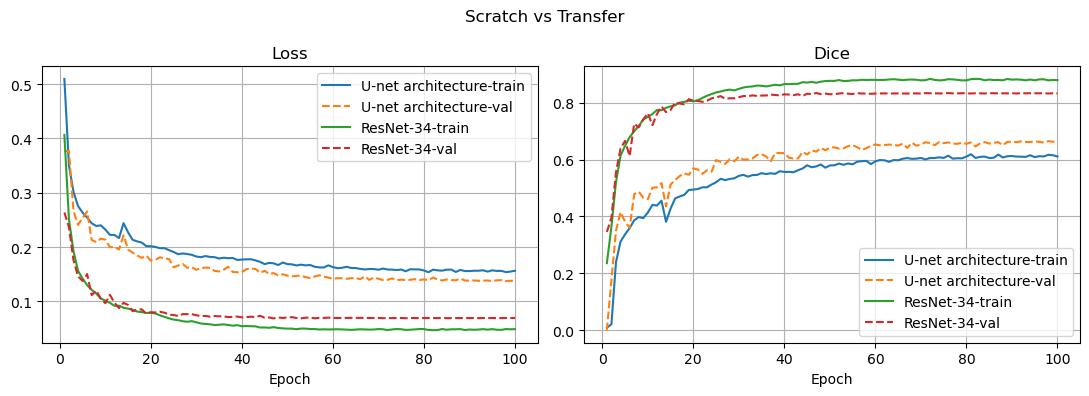

In [ ]:
trL, vaL = build_loaders(PROJECT_ROOT)

scratch = BrainTumorSegmentationModel(1, 1, BASE_CH)
scratch, scratch_path = train_eval(scratch, trL, vaL, epochs=EPOCHS, lr=LR, tag="U-net architecture")


transfer = make_transfer_unet(encoder="resnet34", in_ch=1, out_ch=1, weights="imagenet")
transfer, transfer_path = train_eval(transfer, trL, vaL, epochs=EPOCHS, lr=LR, tag="ResNet-34",
                                     epoch_freeze=2, use_discriminative_lr=True)



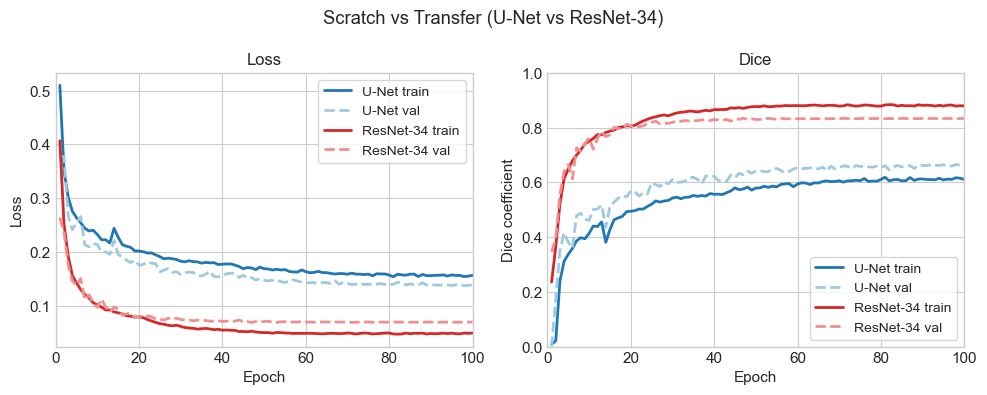

In [13]:
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def load_history(path):
    with open(path, "r") as f:
        return json.load(f)

def plot_histories(files):
    """
    files = [(display_label, json_path), ...]
    """
    histos = [(label, load_history(path)) for label, path in files]
    epochs = range(1, len(histos[0][1]["train_loss"]) + 1)

    # color pairs (train, val)
    color_pairs = {
        "U-Net":  ("#1f77b4", "#9ecae1"),     # dark/light blue
        "ResNet-34": ("#d62728", "#f28e8e"),  # dark/light red
        "EfficientNet": ("#2ca02c", "#98df8a"), # optional green pair
        "VGG16": ("#9467bd", "#c5b0d5"),       # optional purple pair
    }

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(10, 4))

    # ----- Loss -----
    plt.subplot(1, 2, 1)
    for label, h in histos:
        train_c, val_c = color_pairs.get(label, ("gray", "lightgray"))
        plt.plot(epochs, h["train_loss"], color=train_c, label=f"{label} train")
        plt.plot(epochs, h["val_loss"], color=val_c, linestyle="--", label=f"{label} val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.xlim(0, 100)
    plt.legend(frameon=True)

    # ----- Dice -----
    plt.subplot(1, 2, 2)
    for label, h in histos:
        train_c, val_c = color_pairs.get(label, ("gray", "lightgray"))
        plt.plot(epochs, h["train_dice"], color=train_c, label=f"{label} train")
        plt.plot(epochs, h["val_dice"], color=val_c, linestyle="--", label=f"{label} val")
    plt.title("Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice coefficient")
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 1)  # for Dice
    plt.legend(frameon=True)

    plt.suptitle("Scratch vs Transfer (U-Net vs ResNet-34)")
    plt.tight_layout()
    plt.show()

# Example usage
plot_histories([
    ("U-Net", "U-net architecture.json"),
    ("ResNet-34", "ResNet-34.json")
])


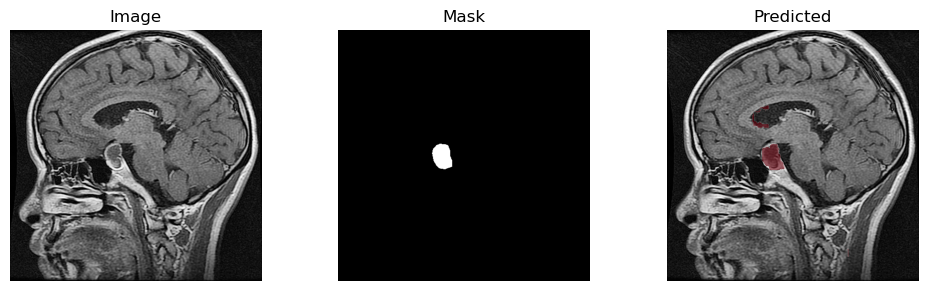

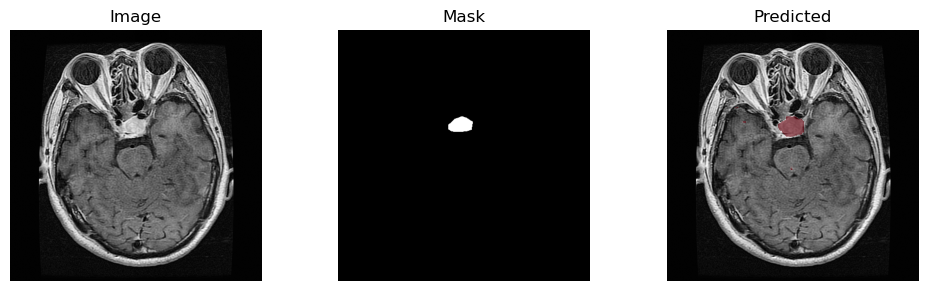

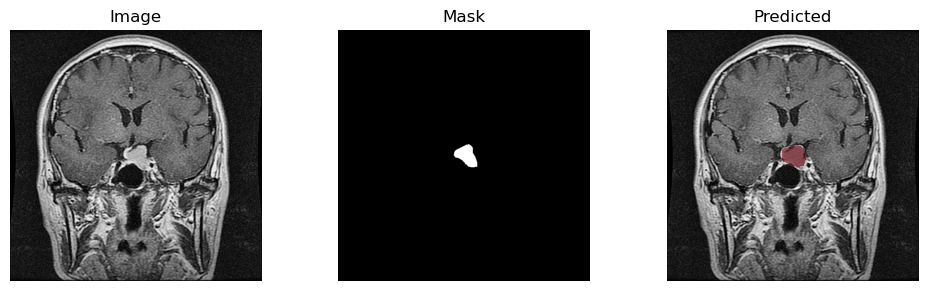

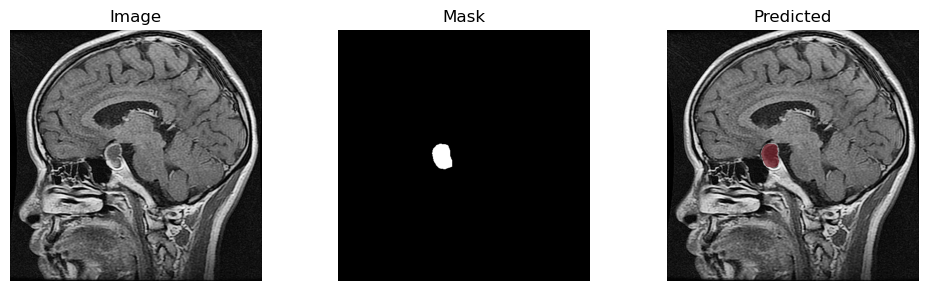

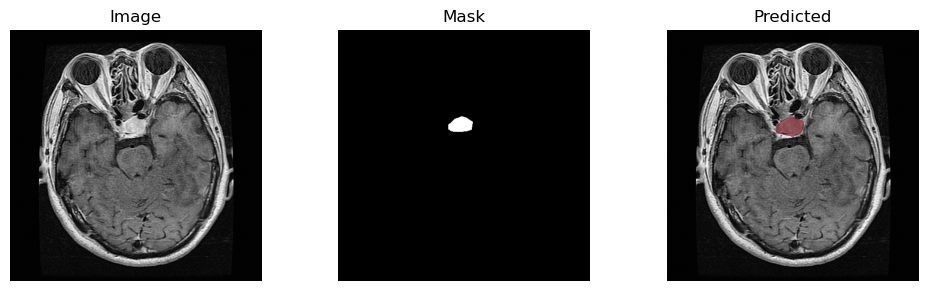

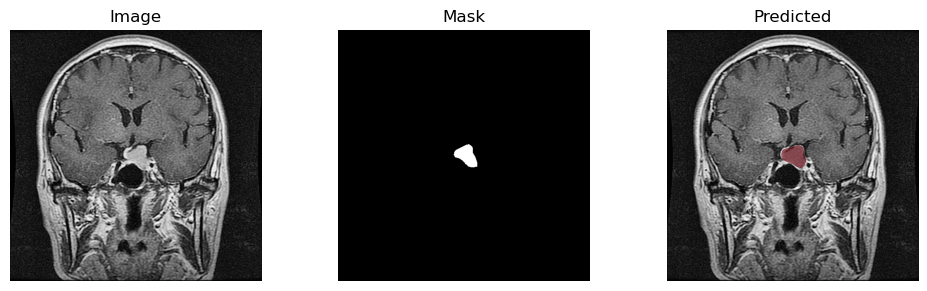

In [ ]:
@torch.no_grad()
def predict_and_plot(model_path, ds, model_type="scratch", thr=0.5):
    state = torch.load(model_path, map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]

    model = (
        smp.Unet(encoder_name="resnet34", encoder_weights=None,
                 in_channels=1, classes=1, activation=None)
        if model_type == "ResNet-34"
        else BrainTumorSegmentationModel(in_ch=1, out_ch=1, base=BASE_CH)
    )
    model.load_state_dict(state)
    model.to(device).eval()

    for i in [10, 50, 100]:
        img_t, mask_t, _ = ds[i]
        img = img_t.permute(1,2,0).numpy().squeeze()
        gt  = mask_t.squeeze().numpy().astype(bool)
        pred = torch.sigmoid(model(img_t.unsqueeze(0).to(device))).cpu().squeeze().numpy() > thr

        _, ax = plt.subplots(1, 3, figsize=(10,3))
        ax[0].imshow(img, cmap="gray"); ax[0].set_title("Image")
        ax[1].imshow(gt, cmap="gray");  ax[1].set_title("Mask")
        ax[2].imshow(img, cmap="gray"); ax[2].imshow(pred, cmap="Reds", alpha=0.6*pred); ax[2].set_title("Predicted")
        [a.axis("off") for a in ax]
        plt.tight_layout(); plt.show()


ds_val = SegmentationDataset(
    f"{PROJECT_ROOT}/val/images",
    f"{PROJECT_ROOT}/val/masks",
    resize=IMG_SIZE,
    preload=True
)

predict_and_plot(scratch_path, ds_val, model_type="U-net architecture")
predict_and_plot(transfer_path, ds_val, model_type="ResNet-34")



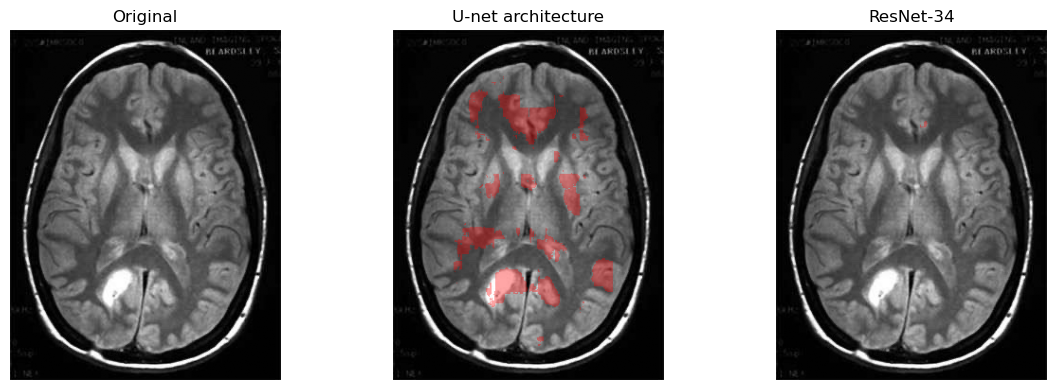

In [14]:
def load_scratch_model(ckpt_path, in_ch=1, out_ch=1, base=BASE_CH):

    m = BrainTumorSegmentationModel(in_ch=in_ch, out_ch=out_ch, base=base).to(device)
    state = torch.load(ckpt_path, map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    m.load_state_dict(state, strict=True)
    m.eval()
    return m

def load_transfer_model(ckpt_path, encoder="resnet34", in_ch=1, out_ch=1):
    
    tm = smp.Unet(
        encoder_name=encoder,
        encoder_weights=None,
        in_channels=in_ch,
        classes=out_ch,
        activation=None
    ).to(device)
    state = torch.load(ckpt_path, map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    tm.load_state_dict(state, strict=True)
    tm.eval()
    return tm

def _prep_image(image_path, resize=IMG_SIZE):
    
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    orig_size = img.shape[:2]
    img_resized = cv2.resize(img, resize, interpolation=cv2.INTER_LINEAR)
    img_t = torch.from_numpy(img_resized).unsqueeze(0).unsqueeze(0).float() / 255.0  

    return img, img_t.to(device), orig_size

@torch.no_grad()
def compare_models_on_image(image_path, models: dict, threshold=0.5, resize=IMG_SIZE):

    img_np, img_t, orig_size = _prep_image(image_path, resize)
    preds = {}

    for name, m in models.items():
        m.eval()
        prob = torch.sigmoid(m(img_t)).cpu().squeeze().numpy()
        mask = (prob > threshold).astype(np.uint8)
        mask = cv2.resize(mask, (orig_size[1], orig_size[0]), interpolation=cv2.INTER_NEAREST)
        preds[name] = mask

    img_disp = img_np.astype(np.float32)
    img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

    ncols = 1 + len(models)
    plt.figure(figsize=(4 * ncols, 4))

    plt.subplot(1, ncols, 1)
    plt.imshow(img_disp, cmap="gray", vmin=0, vmax=1)
    plt.title("Original")
    plt.axis("off")

    for j, (name, mask) in enumerate(preds.items(), start=2):
        plt.subplot(1, ncols, j)
        plt.imshow(img_disp, cmap="gray", vmin=0, vmax=1)

        red_overlay = np.zeros((*mask.shape, 4))  
        red_overlay[..., 0] = 1.0        
        red_overlay[..., 3] = 0.35 * mask  

        plt.imshow(red_overlay)
        plt.title(name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    return preds

scratch_ckpt  = Path(PROJECT_ROOT) / "U-net architecture.pt"               
transfer_ckpt = Path(PROJECT_ROOT) / "ResNet-34.pt"       

TRANSFER_ENCODER = "resnet34"

scratch_model  = load_scratch_model(scratch_ckpt, in_ch=1, out_ch=1, base=BASE_CH)
transfer_model = load_transfer_model(transfer_ckpt, encoder=TRANSFER_ENCODER, in_ch=1, out_ch=1)

test_image = Path(PROJECT_ROOT) / "Test" / "IMG_3422.PNG"
pred_masks = compare_models_on_image(test_image, {
    "U-net architecture": scratch_model,
    "ResNet-34": transfer_model
}, threshold=0.5)